In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Perceptron
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
from matplotlib import gridspec
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
from mlxtend.plotting import plot_decision_regions
import warnings
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
from ucimlrepo import fetch_ucirepo 
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

simplefilter("ignore", category=ConvergenceWarning)

warnings.filterwarnings('ignore')

# Просмотр данных

![image info](./home-credit-default-risk/schema.png)

**Описание файлов данных**

- application_{train|test}.csv
  - Это основная таблица, разделенная на два файла для обучения (с целью — TARGET) и для тестирования (без цели — TARGET).
  - Содержит статические данные для всех заявок. Одна строка представляет один кредит в нашем выборочном наборе данных.

- bureau.csv
  - Все предыдущие кредиты клиента, предоставленные другими финансовыми учреждениями, о которых сообщалось в кредитное бюро (для клиентов, имеющих кредит в нашем наборе).
  - Для каждого кредита в нашей выборке имеется столько строк, сколько кредитов клиент имел в кредитном бюро до даты подачи заявки.

- bureau_balance.csv
  - Ежемесячные балансы предыдущих кредитов в кредитном бюро.
  - Эта таблица содержит одну строку за каждый месяц истории каждого предыдущего кредита, о котором сообщалось в кредитное бюро, — т.е. таблица имеет (#кредитов в выборке * #относительных предыдущих кредитов * #месяцев, в которых у нас есть наблюдаемая история предыдущих кредитов) строк.

- POS_CASH_balance.csv
  - Ежемесячные снимки балансов предыдущих ПВЗ (пунктов выдачи заказов) и наличных кредитов заявителя, взятых в Home Credit.
  - Эта таблица содержит одну строку за каждый месяц истории каждого предыдущего кредита в Home Credit (потребительский кредит и наличные кредиты), связанного с кредитами в нашей выборке — т.е. таблица имеет (#кредитов в выборке * #относительных предыдущих кредитов * #месяцев, в которых у нас есть наблюдаемая история предыдущих кредитов) строк.

- credit_card_balance.csv
  - Ежемесячные снимки балансов предыдущих кредитных карт, которыми владеет заявитель в Home Credit.
  - Эта таблица повторяет структуру для предыдущих кредитов, то есть содержит одну строку за каждый месяц истории каждой предыдущей кредитной карты в Home Credit, связанной с кредитами в нашей выборке.

- previous_application.csv
  - Все предыдущие заявки на кредиты в Home Credit клиентов, имеющих кредиты в нашей выборке.
  - Каждая строка соответствует одной предыдущей заявке, связанной с кредитами в нашем наборе данных.

- installments_payments.csv
  - История погашений по ранее выданным кредитам в Home Credit, связанным с кредитами в нашей выборке.
  - Содержит: а) одну строку за каждый произведенный платеж плюс б) одну строку за каждую пропущенную оплату.
  - Одна строка эквивалентна одному платежу одной доли или одной доли, соответствующей одному платежу одного предыдущего кредита Home Credit, связанного с кредитами в нашей выборке.

- HomeCredit_columns_description.csv
  - Этот файл содержит описания столбцов в различных файлах данных.

In [560]:
application = pd.read_csv("/Users/tsarevivan/Downloads/home-credit-default-risk/application_train.csv")
application_train, application_test = train_test_split(application, test_size=0.2, random_state=42)

In [27]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
123473,243191,0,Cash loans,F,Y,N,0,171000.0,555273.0,16366.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
10118,111778,0,Cash loans,M,N,Y,1,157500.0,198085.5,23638.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
64716,175057,1,Cash loans,M,Y,Y,0,135000.0,776304.0,25173.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,5.0
234940,372147,0,Cash loans,M,Y,Y,1,164133.0,900000.0,36787.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,3.0
236051,373412,0,Cash loans,M,N,Y,0,225000.0,533668.5,21294.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0


In [28]:
columns_description = pd.read_csv("/Users/tsarevivan/Downloads/home-credit-default-risk/HomeCredit_columns_description.csv")

In [29]:
main_features = columns_description["Row"].head(33)
main_features

0                      SK_ID_CURR
1                          TARGET
2              NAME_CONTRACT_TYPE
3                     CODE_GENDER
4                    FLAG_OWN_CAR
5                 FLAG_OWN_REALTY
6                    CNT_CHILDREN
7                AMT_INCOME_TOTAL
8                      AMT_CREDIT
9                     AMT_ANNUITY
10                AMT_GOODS_PRICE
11                NAME_TYPE_SUITE
12               NAME_INCOME_TYPE
13            NAME_EDUCATION_TYPE
14             NAME_FAMILY_STATUS
15              NAME_HOUSING_TYPE
16     REGION_POPULATION_RELATIVE
17                     DAYS_BIRTH
18                  DAYS_EMPLOYED
19              DAYS_REGISTRATION
20                DAYS_ID_PUBLISH
21                    OWN_CAR_AGE
22                     FLAG_MOBIL
23                 FLAG_EMP_PHONE
24                FLAG_WORK_PHONE
25               FLAG_CONT_MOBILE
26                     FLAG_PHONE
27                     FLAG_EMAIL
28                OCCUPATION_TYPE
29            

In [30]:
categorical_cols = application_train.select_dtypes(include=['object']).columns

# Инициализация LabelEncoder
le = LabelEncoder()

# Кодирование каждого категориального столбца в класс (числовое представление)
for col in categorical_cols:
    application_train[col] = le.fit_transform(application_train[col])
None

In [31]:
categorical_cols_test = application_test.select_dtypes(include=['object']).columns

# Инициализация LabelEncoder
le = LabelEncoder()

# Кодирование каждого категориального столбца в класс (числовое представление)
for col in categorical_cols:
    application_test[col] = le.fit_transform(application_test[col])
None

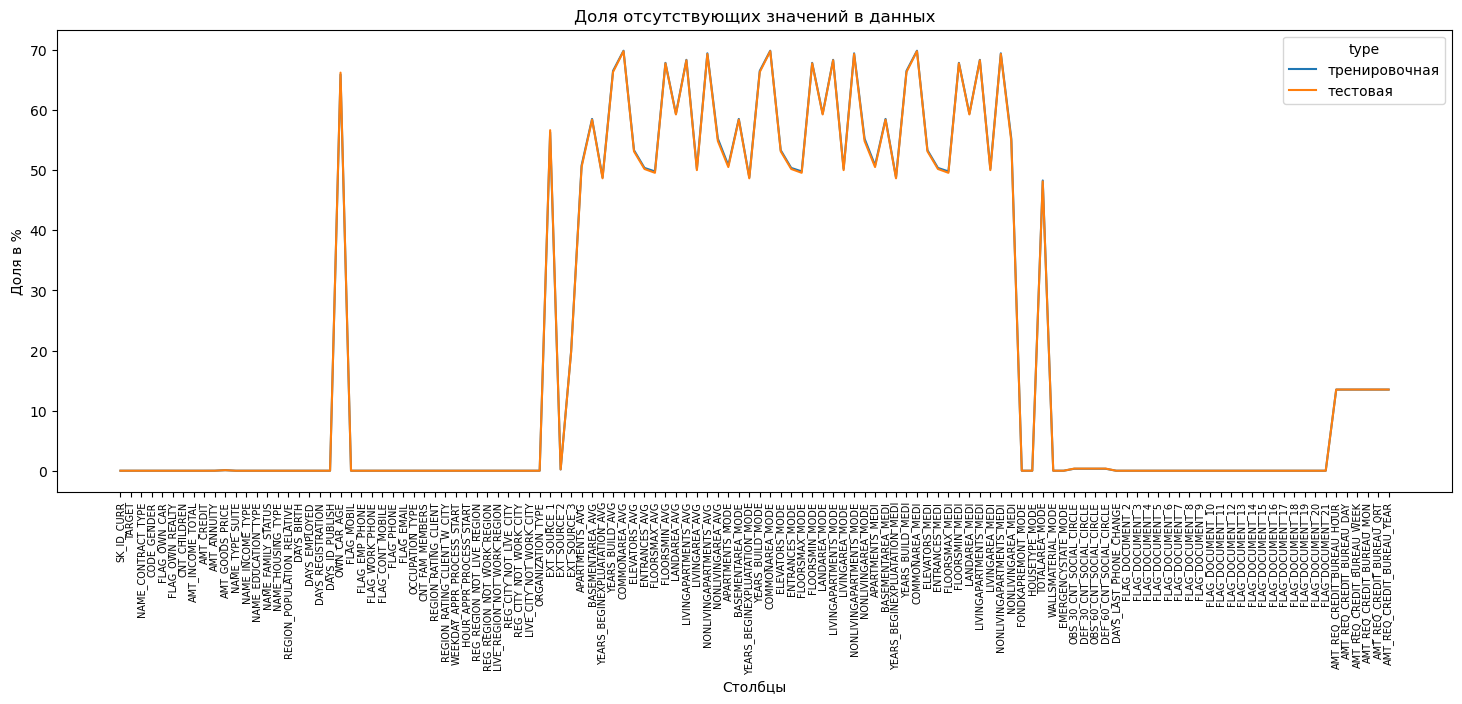

In [32]:
fig = plt.figure(figsize=(18, 6))

miss_train = pd.DataFrame((application_train.isnull().sum()) * 100 / application_train.shape[0]).reset_index()
miss_test = pd.DataFrame((application_test.isnull().sum()) * 100 / application_test.shape[0]).reset_index()

miss_train.columns = ['feature', 'missing_percent']
miss_test.columns = ['feature', 'missing_percent']

miss_train["type"] = "тренировочная"
miss_test["type"] = "тестовая"

missing = pd.concat([miss_train, miss_test], axis=0)

ax = sns.lineplot(x="feature", y="missing_percent", data=missing, hue="type")
plt.xticks(rotation=90, fontsize=7)
plt.title("Доля отсутствующих значений в данных")
plt.ylabel("Доля в %")
plt.xlabel("Столбцы")
None

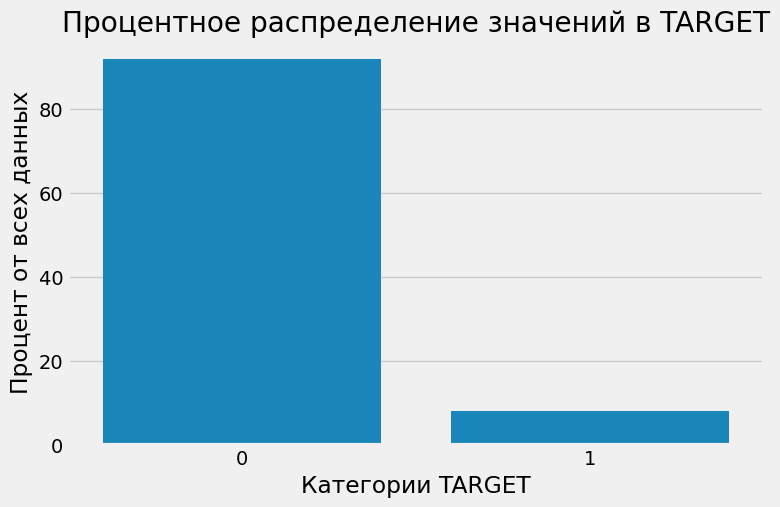

In [33]:
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = [8, 5]


total_count = len(application_train)
value_counts = application_train['TARGET'].value_counts()
percentages = (value_counts / total_count) * 100

ax = sns.barplot(x=percentages.index, y=percentages.values)

plt.title("Процентное распределение значений в TARGET")
plt.ylabel("Процент от всех данных")
plt.xlabel("Категории TARGET")


plt.show()

Итого имеем процент дефолтов:

In [35]:
percentages.values[1]

8.079412051640597

In [36]:
np.abs(application_train.drop(columns=['SK_ID_CURR']).corr()['TARGET']).sort_values(ascending=False).head(30)

TARGET                         1.000000
EXT_SOURCE_3                   0.180096
EXT_SOURCE_2                   0.158824
EXT_SOURCE_1                   0.154135
DAYS_BIRTH                     0.077632
REGION_RATING_CLIENT_W_CITY    0.060598
REGION_RATING_CLIENT           0.058058
CODE_GENDER                    0.054790
DAYS_LAST_PHONE_CHANGE         0.053825
NAME_EDUCATION_TYPE            0.053759
DAYS_ID_PUBLISH                0.052218
REG_CITY_NOT_WORK_CITY         0.051017
FLAG_EMP_PHONE                 0.045673
NAME_INCOME_TYPE               0.044905
DAYS_EMPLOYED                  0.044640
FLAG_DOCUMENT_3                0.044548
REG_CITY_NOT_LIVE_CITY         0.044483
FLOORSMAX_AVG                  0.044281
FLOORSMAX_MEDI                 0.043838
FLOORSMAX_MODE                 0.043344
DAYS_REGISTRATION              0.041712
EMERGENCYSTATE_MODE            0.041426
AMT_GOODS_PRICE                0.040660
HOUSETYPE_MODE                 0.039450
REGION_POPULATION_RELATIVE     0.036909


Во многих столбцах есть пропуски, в модели можно будет их заполнять медианой/средним значением

## Внешние скоры

Видно, что очень сильно коррелируют с таргетом внешние скоры, поэтому посмотрим на них в отдельности:

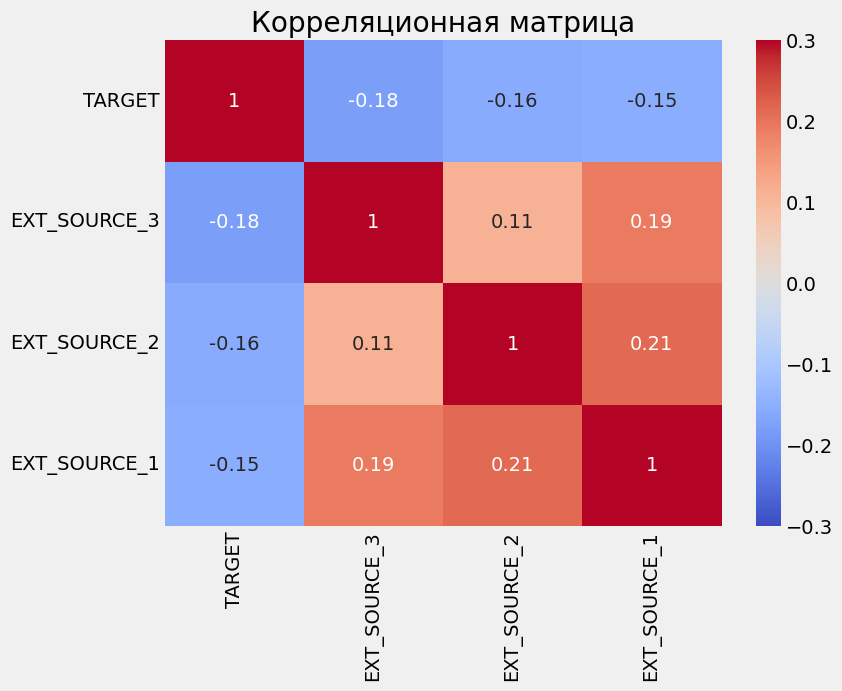

In [40]:
corr_matrix = application_train[["TARGET", "EXT_SOURCE_3", "EXT_SOURCE_2", "EXT_SOURCE_1"]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin = -0.3, vmax=0.3)
plt.title('Корреляционная матрица')
plt.show()
None

In [41]:
application_train['ext_score_1'] = application_train['EXT_SOURCE_1'].fillna(-1).apply(lambda x: np.round(x, 2))
application_train['ext_score_2'] = application_train['EXT_SOURCE_2'].fillna(-1).apply(lambda x: np.round(x, 2))
application_train['ext_score_3'] = application_train['EXT_SOURCE_3'].fillna(-1).apply(lambda x: np.round(x, 2))

In [42]:
application_train[['ext_score_1', 'ext_score_2', 'ext_score_3']]

,ext_score_1,ext_score_2,ext_score_3
123473,0.52,0.36,0.56
10118,0.24,0.49,0.60
64716,-1.00,0.64,0.71
234940,0.29,0.43,0.51
236051,0.79,0.45,0.53
...,...,...,...
119879,-1.00,0.62,-1.00
259178,0.46,0.72,0.37
131932,0.31,0.61,0.55
146867,0.61,0.60,0.26


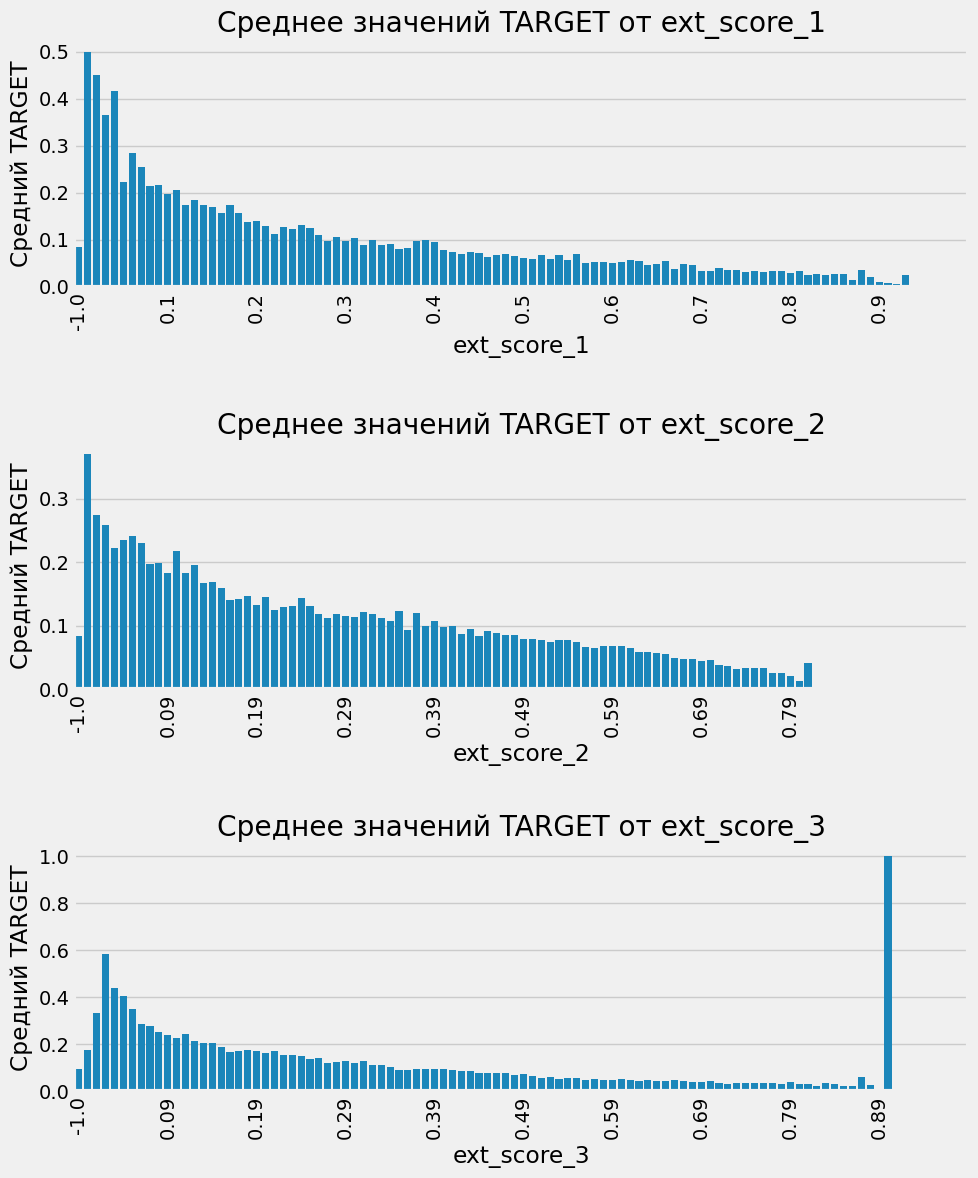

In [43]:
plt.figure(figsize=(10, 12))

for i, source in enumerate(['ext_score_1', 'ext_score_2', 'ext_score_3']):
    plt.subplot(3, 1, i + 1)
    
    mean_target_by_source = application_train.groupby(source)['TARGET'].mean().reset_index()
    sns.barplot(x=source, y='TARGET', data=mean_target_by_source)
    plt.xticks(rotation=90, ticks=np.arange(0, 110, 10))
    plt.title(f'Среднее значений TARGET от {source}')
    plt.xlabel(f'{source}')
    plt.ylabel('Средний TARGET')

plt.tight_layout(h_pad=2.5)
plt.show()

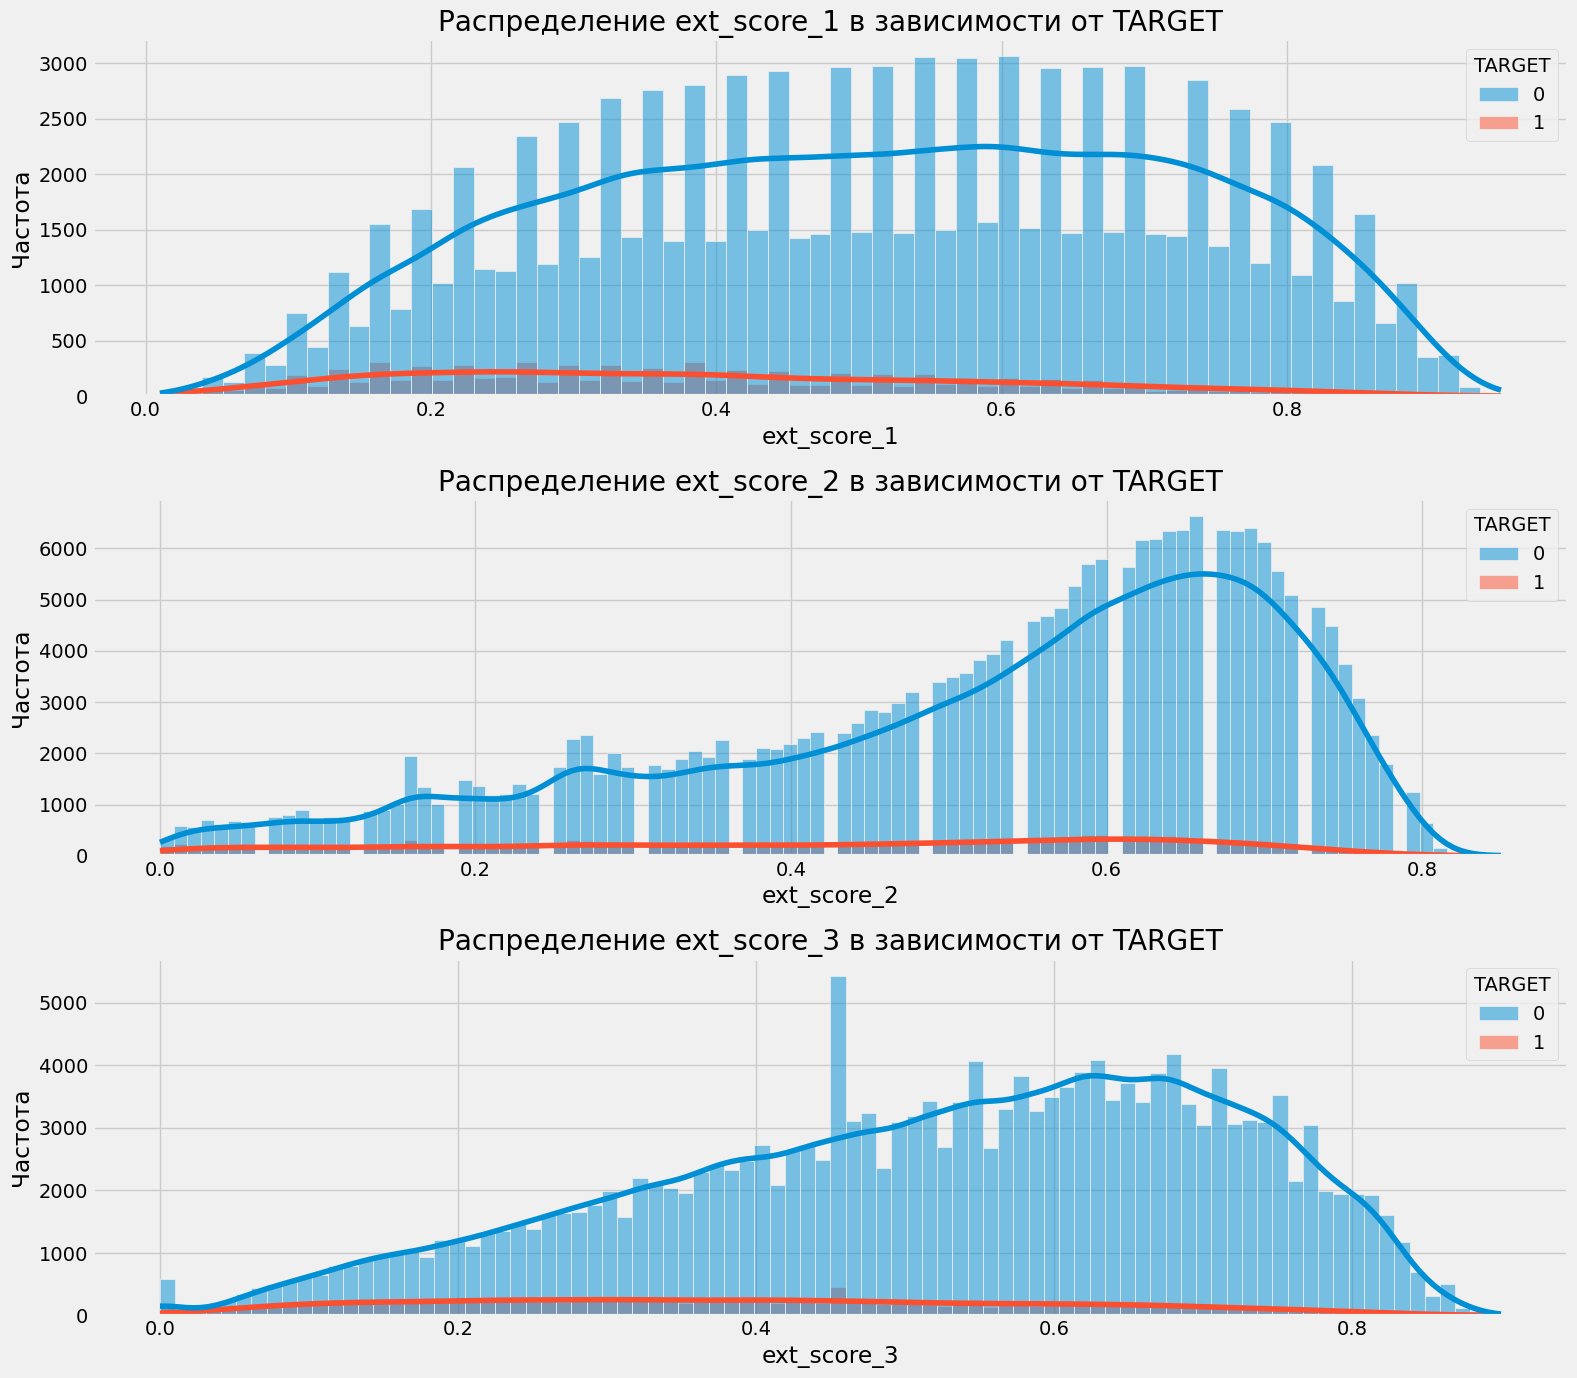

In [44]:
fig, axes = plt.subplots(3, 1, figsize=(16, 14))

for i, feature in enumerate(['ext_score_1', 'ext_score_2', 'ext_score_3']):
    filtered_data = application_train[application_train[feature] >= 0]
    
    sns.histplot(data=filtered_data, x=feature, hue='TARGET', kde=True, ax=axes[i])
    
    axes[i].set_title(f'Распределение {feature} в зависимости от TARGET')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Частота')

plt.tight_layout()
plt.show()

## Возраст

In [46]:
application_train['client_age'] = np.round(abs(application_train['DAYS_BIRTH']) / 365)

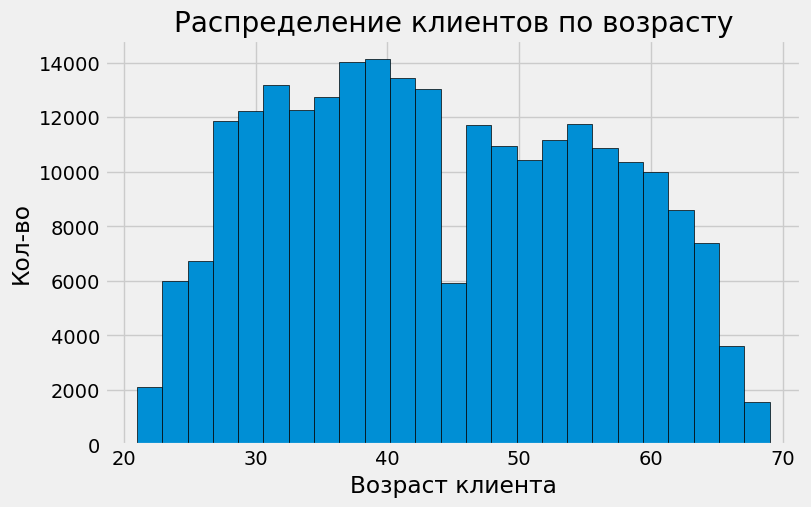

In [47]:
plt.hist(application_train['client_age'], edgecolor = 'k', bins = 25)
plt.title('Распределение клиентов по возрасту'); 
plt.xlabel('Возраст клиента'); 
plt.ylabel('Кол-во');

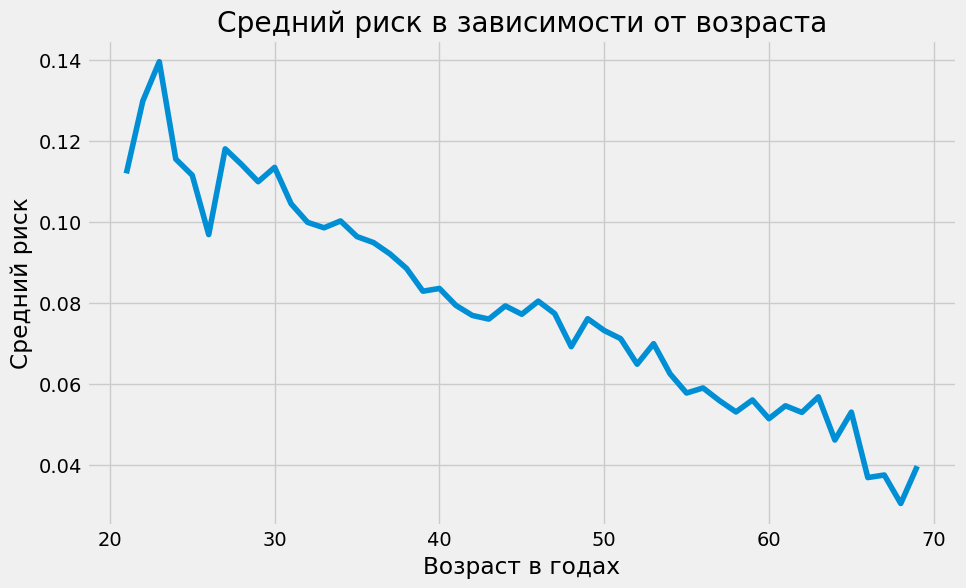

In [48]:
age_target_mean = application_train.groupby('client_age')['TARGET'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=age_target_mean, x='client_age', y='TARGET')

plt.xlabel('Возраст в годах')
plt.ylabel('Средний риск')
plt.title('Средний риск в зависимости от возраста')
plt.show()

# Начинаем применять модели

In [582]:
def show_feature_importances(model, features):
    plt.figure(figsize = (12, 8))
    
    results = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
    results = results.sort_values('importance', ascending = False)
    
    results.head(20).plot(x = 'feature', y = 'importance', kind = 'barh',
                     color = 'red', edgecolor = 'k', title = 'Feature Importances');

In [584]:
def check_metrics(results_df):
    true_labels = results_df['TARGET']
    predicted_labels = results_df['PREDICT_TARGET']
    predicted_scores = results_df['SCORE']
    
    roc_auc = roc_auc_score(true_labels, predicted_scores)
    accuracy = accuracy_score(true_labels, predicted_labels)
    
    report = classification_report(true_labels, predicted_labels)
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(report)
    
    results_df['Rounded_SCORE'] = np.round(results_df['SCORE'], 2)
    mean_target_by_score = results_df.groupby('Rounded_SCORE')['TARGET'].mean()
    count_by_score = results_df.groupby('Rounded_SCORE')['TARGET'].count()
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_xlabel('score')
    ax1.set_ylabel('Средний риск')
    ax1.plot(mean_target_by_score.index, mean_target_by_score.values, 'o-', color='b', label='Средний риск')
    ax1.tick_params(axis='y')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Кол-во людей')
    ax2.plot(count_by_score.index, count_by_score.values, 'o-', color='r', label='Кол-во людей')
    ax2.tick_params(axis='y')
    
    fig.suptitle('Средний риск и распределение людей по скору')
    ax1.grid(True)
    fig.legend()

In [586]:
def preprocess(train, test):
    # Берем id
    train_id = train['SK_ID_CURR']
    test_id = test['SK_ID_CURR']
    # Разделяем целевую переменную и убираем некотрые признаки из тренировочных данных
    train_labels = train['TARGET']
    test_labels = test['TARGET']
    
    # Исключаем 'TARGET' и другие указанные столбцы из тренировочного набора
    train = train.drop(labels=['SK_ID_CURR', 'TARGET'], axis=1)
    test = test.drop(labels=['SK_ID_CURR', 'TARGET'], axis=1)
    
    categorical_cols_train = train.select_dtypes(include=['object']).columns
    # Инициализация LabelEncoder
    le = LabelEncoder()
    
    # Кодирование каждого категориального столбца в класс (числовое представление)
    for col in categorical_cols_train:
        train[col] = le.fit_transform(train[col])
        test[col] = le.fit_transform(test[col])

    # Создаем и применяем SimpleImputer для заполнения недостающих значений медианой
    imputer = SimpleImputer(strategy='median')
    train_imputed = imputer.fit_transform(train)
    test_imputed = imputer.transform(test)

    # Создаем и применяем MinMaxScaler для нормализации
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train_imputed)
    test_scaled = scaler.transform(test_imputed)

    # Преобразуем обратно в DataFrame для удобства
    train_final = pd.DataFrame(train_scaled, columns=train.columns)
    test_final = pd.DataFrame(test_scaled, columns=test.columns)

    # Выводим размерности полученных наборов данных
    print('Размер тренировочной выборки: ', train_final.shape)
    print('Размер тестовой выборки: ', test_final.shape)
    return train_id, test_id, train_final, train_labels, test_final, test_labels

# Only Application

In [641]:
application_train, application_test = train_test_split(application, test_size=0.2, random_state=42)

In [643]:
application_train_id, application_test_id, application_train, application_train_labels, application_test, application_test_labels = \
preprocess(application_train, application_test)

Размер тренировочной выборки:  (246008, 120)
Размер тестовой выборки:  (61503, 120)


## Logistic Regression

In [665]:
def train_and_evaluate_logreg(train_id, test_id, train_final, train_labels, test_final, test_labels):
    log_reg = LogisticRegression(C = 0.0001)
    
    log_reg.fit(train_final, train_labels)

    logreg_solution = pd.DataFrame({
        'SK_ID_CURR': test_id,
        'TARGET': test_labels,
        'SCORE': log_reg.predict_proba(test_final)[:, 1],
        'PREDICT_TARGET': log_reg.predict(test_final)
    })

    check_metrics(logreg_solution)

ROC-AUC: 0.6860
Accuracy: 0.9195

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56554
           1       0.00      0.00      0.00      4949

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503



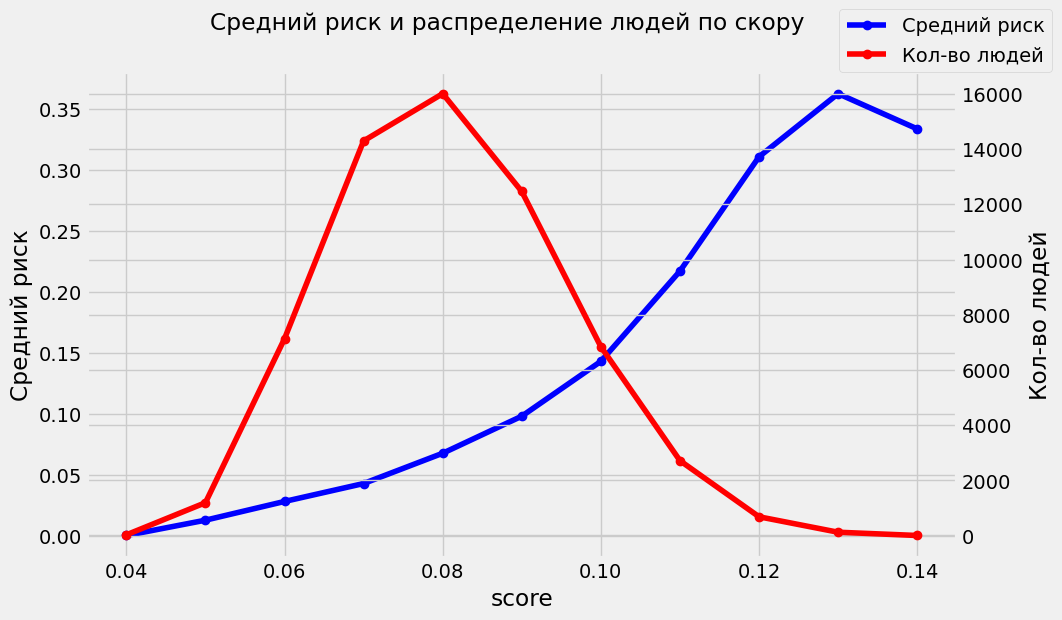

In [669]:
train_and_evaluate_logreg(application_train_id, application_test_id, \
                            application_train, application_train_labels, \
                            application_test, application_test_labels)

## Gradient Boosting

In [653]:
def train_and_evaluate_boosting(train_id, test_id, train_final, train_labels, test_final, test_labels):
    clf = LGBMClassifier()
    
    clf.fit(train_final, train_labels)

    clf_solution = pd.DataFrame({
        'SK_ID_CURR': test_id,
        'TARGET': test_labels,
        'SCORE': clf.predict_proba(test_final)[:, 1],
        'PREDICT_TARGET': clf.predict(test_final)
    })

    check_metrics(clf_solution)
    show_feature_importances(clf, train_final.columns)

[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11231
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 115
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
ROC-AUC: 0.7568
Accuracy: 0.9197

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56554
           1       0.52      0.02      0.04      4949

    accuracy                           0.92     61503
   macro avg       0.72      0.51      0.50     61503
weighted avg       0.89      0.92      0.88     61503



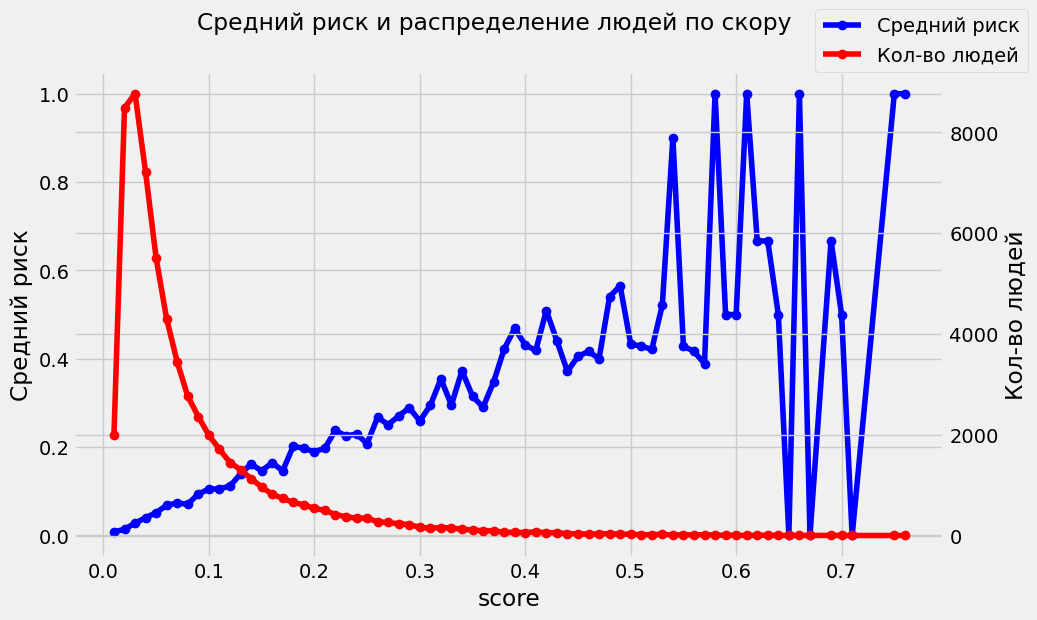

<Figure size 1200x800 with 0 Axes>

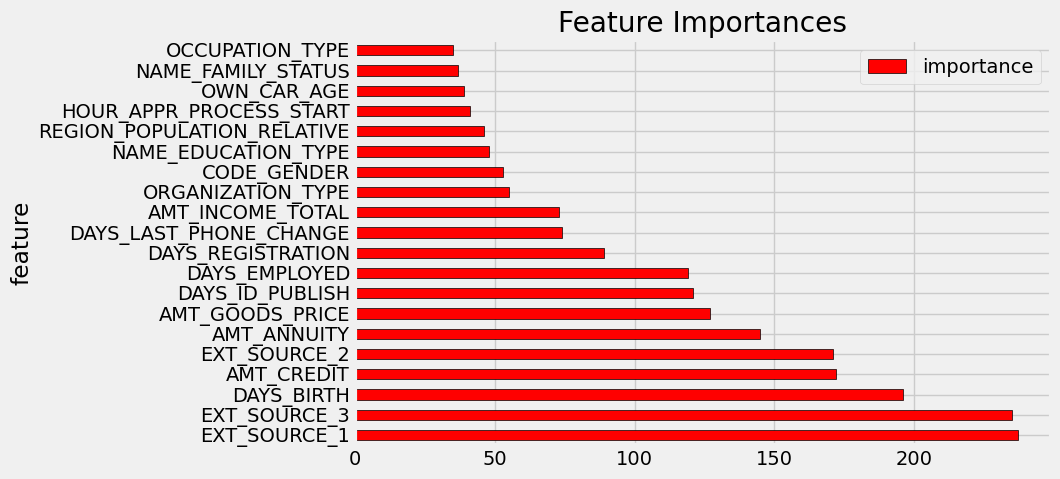

In [655]:
train_and_evaluate_boosting(application_train_id, application_test_id, \
                            application_train, application_train_labels, \
                            application_test, application_test_labels)

## CatBoostClassifier

In [657]:
def train_and_evaluate_catboost(train_id, test_id, train_final, train_labels, test_final, test_labels):
    catboost = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        eval_metric='AUC',
        random_seed=42,
        logging_level='Silent',
        early_stopping_rounds=100
    )
    
    catboost.fit(train_final, train_labels, eval_set=(test_final, test_labels))

    catboost_solution = pd.DataFrame({
        'SK_ID_CURR': test_id,
        'TARGET': test_labels,
        'SCORE': catboost.predict_proba(test_final)[:, 1],
        'PREDICT_TARGET': catboost.predict(test_final)
    })

    check_metrics(catboost_solution)
    show_feature_importances(catboost, train_final.columns)

ROC-AUC: 0.7612
Accuracy: 0.9199

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56554
           1       0.56      0.02      0.04      4949

    accuracy                           0.92     61503
   macro avg       0.74      0.51      0.50     61503
weighted avg       0.89      0.92      0.88     61503



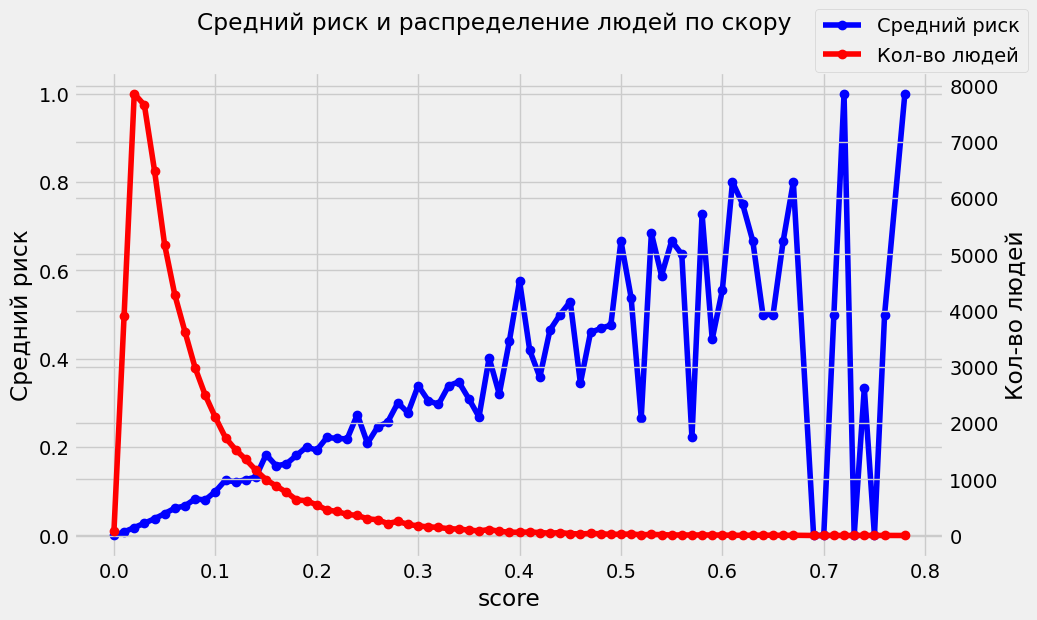

<Figure size 1200x800 with 0 Axes>

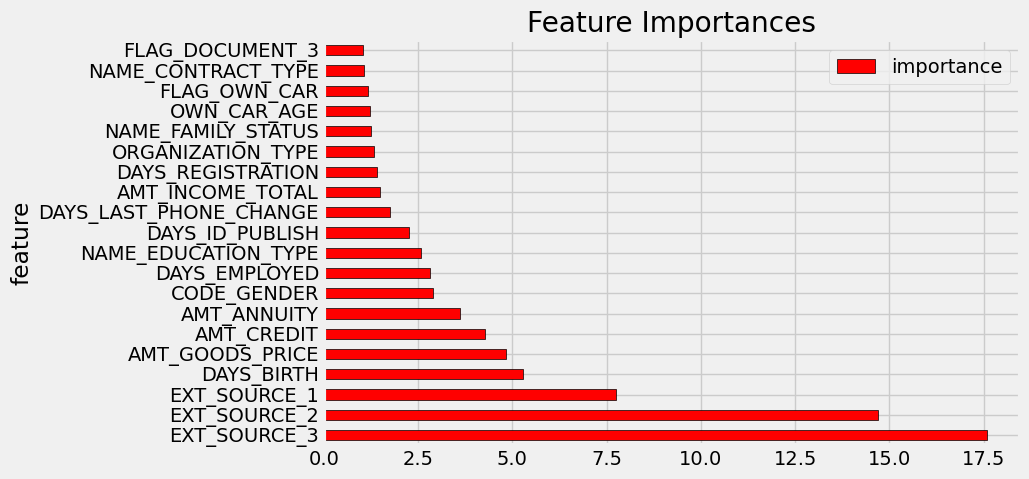

In [659]:
train_and_evaluate_catboost(application_train_id, application_test_id, \
                            application_train, application_train_labels, \
                            application_test, application_test_labels)

# С остальными таблицами

| Column Name               | Description                                                                 |
|---------------------------|-----------------------------------------------------------------------------|
| SK_ID_CURR                | ID займа в выборке - один заем может иметь несколько связанных предыдущих кредитов |
| SK_BUREAU_ID              | ID предыдущего кредита в БК, связанного с нашим займом                        |
| CREDIT_ACTIVE             | Статус кредита по отчету кредитного бюро                                      |
| CREDIT_CURRENCY           | Валюта кредита                                                               |
| DAYS_CREDIT               | Сколько дней до текущей заявки клиент подавал заявку на кредит в БК            |
| CREDIT_DAY_OVERDUE        | Количество дней просрочки по кредиту БК на момент заявки                      |
| DAYS_CREDIT_ENDDATE       | Оставшаяся длительность кредита БК на момент заявки                           |
| DAYS_ENDDATE_FACT         | Прошедшие дни с момента закрытия кредита на момент заявки                     |
| AMT_CREDIT_MAX_OVERDUE    | Максимальная сумма просрочки по кредиту БК к настоящему времени               |
| CNT_CREDIT_PROLONG        | Сколько раз кредит в БК был продлен                                          |
| AMT_CREDIT_SUM            | Текущая сумма кредита в БК                                                   |
| AMT_CREDIT_SUM_DEBT       | Текущая задолженность по кредиту в БК                                        |
| AMT_CREDIT_SUM_LIMIT      | Текущий лимит кредитки, зарегистрированной в БК                              |
| AMT_CREDIT_SUM_OVERDUE    | Текущая сумма просрочки по кредиту в БК                                      |
| CREDIT_TYPE               | Тип кредита в кредитном бюро (авто, наличные и т.д.)                         |
| DAYS_CREDIT_UPDATE        | Сколько дней до заявки последняя информация по кредиту в БК поступила        |
| AMT_ANNUITY               | Аннуитет кредита в кредитном бюро                                            |

In [596]:
previous_application = pd.read_csv('/Users/tsarevivan/Downloads/home-credit-default-risk/previous_application.csv')
bureau = pd.read_csv('/Users/tsarevivan/Downloads/home-credit-default-risk/bureau.csv')
bureau_balance = pd.read_csv('/Users/tsarevivan/Downloads/home-credit-default-risk/bureau_balance.csv')
credit_card_balance  = pd.read_csv('/Users/tsarevivan/Downloads/home-credit-default-risk/credit_card_balance.csv')
POS_CASH  = pd.read_csv('/Users/tsarevivan/Downloads/home-credit-default-risk/POS_CASH_balance.csv')
installments_payments = pd.read_csv('/Users/tsarevivan/Downloads/home-credit-default-risk/installments_payments.csv')

In [597]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [598]:
bureau_balance.STATUS.value_counts()

STATUS
C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: count, dtype: int64

С — closed, то есть погашенный кредит. X — неизвестный статус. 0 — текущий кредит, отсутствие просрочек. 1 — просрочка 1-30 дней, 2 — просрочка 31-60 дней и так далее до статуса 5 — кредит продан третьей стороне или списан.

In [600]:
bureau_balance['STATUS'] = bureau_balance['STATUS'].replace({'X': 0, 'C': 0}).astype(int)

bureau_balance_agg = bureau_balance.groupby('SK_ID_BUREAU').agg(
    DEPT_STATUS=('STATUS', 'max'),
    MONTH_IN_DEPT=('STATUS', lambda x: (x > 0).sum())
).reset_index()
bureau_balance_agg.head()

,SK_ID_BUREAU,DEPT_STATUS,MONTH_IN_DEPT
0,5001709,0,0
1,5001710,0,0
2,5001711,0,0
3,5001712,0,0
4,5001713,0,0


In [601]:
bureau_balance_agg.DEPT_STATUS.value_counts()

DEPT_STATUS
0    714131
1     87055
2      7841
5      5214
3      2077
4      1077
Name: count, dtype: int64

In [602]:
bureau_all = pd.merge(bureau, bureau_balance_agg, on='SK_ID_BUREAU', how='left')
bureau_all.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,DEPT_STATUS,MONTH_IN_DEPT
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN,NaN,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN,NaN,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN,NaN,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN,NaN,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN,NaN,NaN


In [603]:
bureau_all.isna().mean() * 100

SK_ID_CURR                 0.000000
SK_ID_BUREAU               0.000000
CREDIT_ACTIVE              0.000000
CREDIT_CURRENCY            0.000000
DAYS_CREDIT                0.000000
CREDIT_DAY_OVERDUE         0.000000
DAYS_CREDIT_ENDDATE        6.149573
DAYS_ENDDATE_FACT         36.916958
AMT_CREDIT_MAX_OVERDUE    65.513264
CNT_CREDIT_PROLONG         0.000000
AMT_CREDIT_SUM             0.000757
AMT_CREDIT_SUM_DEBT       15.011932
AMT_CREDIT_SUM_LIMIT      34.477415
AMT_CREDIT_SUM_OVERDUE     0.000000
CREDIT_TYPE                0.000000
DAYS_CREDIT_UPDATE         0.000000
AMT_ANNUITY               71.473490
DEPT_STATUS               54.885728
MONTH_IN_DEPT             54.885728
dtype: float64

In [604]:
categorical_cols = ['CREDIT_CURRENCY', 'CREDIT_ACTIVE', 'CREDIT_TYPE']

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    bureau_all[col] = le.fit_transform(bureau_all[col])
    label_encoders[col] = le

In [605]:
agg_dict = {
    'MAX_MONTH_IN_DEPT': ('MONTH_IN_DEPT', 'max'),
    'MAX_DEPT_STATUS': ('DEPT_STATUS', 'max'),
    'MAX_CREDIT_DAY_OVERDUE': ('CREDIT_DAY_OVERDUE', 'max'),
    'MAX_AMT_CREDIT_MAX_OVERDUE': ('AMT_CREDIT_MAX_OVERDUE', 'max'),
    'MAX_AMT_CREDIT_SUM_DEBT': ('AMT_CREDIT_SUM_DEBT', 'max')
}

mean_agg = {col: (col, 'mean') for col in bureau_all.columns if col not in ['SK_ID_CURR', 'SK_ID_BUREAU']}
agg_dict.update(mean_agg)

bureau_agg = bureau_all.groupby('SK_ID_CURR').agg(**agg_dict).reset_index()

bureau_agg.head()

,SK_ID_CURR,MAX_MONTH_IN_DEPT,MAX_DEPT_STATUS,MAX_CREDIT_DAY_OVERDUE,MAX_AMT_CREDIT_MAX_OVERDUE,MAX_AMT_CREDIT_SUM_DEBT,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,...,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,DEPT_STATUS,MONTH_IN_DEPT
0,100001,1.0,1.0,0,NaN,373239.0,1.142857,0.0,-735.000000,0.0,...,0.0,207623.571429,85240.928571,0.00000,0.0,3.000000,-93.142857,3545.357143,0.142857,0.142857
1,100002,6.0,1.0,0,5043.645,245781.0,1.500000,0.0,-874.000000,0.0,...,0.0,108131.945625,49156.200000,7997.14125,0.0,3.500000,-499.875000,0.000000,0.750000,3.375000
2,100003,NaN,NaN,0,0.000,0.0,1.500000,0.0,-1400.750000,0.0,...,0.0,254350.125000,0.000000,202500.00000,0.0,3.500000,-816.000000,NaN,NaN,NaN
3,100004,NaN,NaN,0,0.000,0.0,2.000000,0.0,-867.000000,0.0,...,0.0,94518.900000,0.000000,0.00000,0.0,3.000000,-532.000000,NaN,NaN,NaN
4,100005,0.0,0.0,0,0.000,543087.0,0.666667,0.0,-190.666667,0.0,...,0.0,219042.000000,189469.500000,0.00000,0.0,3.333333,-54.333333,1420.500000,0.000000,0.000000


In [612]:
bureau_with_target = pd.merge(bureau_agg, application[['SK_ID_CURR', 'TARGET']], on='SK_ID_CURR', how='left')

bureau_with_target.head()

,SK_ID_CURR,MAX_MONTH_IN_DEPT,MAX_DEPT_STATUS,MAX_CREDIT_DAY_OVERDUE,MAX_AMT_CREDIT_MAX_OVERDUE,MAX_AMT_CREDIT_SUM_DEBT,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,...,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,DEPT_STATUS,MONTH_IN_DEPT,TARGET
0,100001,1.0,1.0,0,NaN,373239.0,1.142857,0.0,-735.000000,0.0,...,207623.571429,85240.928571,0.00000,0.0,3.000000,-93.142857,3545.357143,0.142857,0.142857,NaN
1,100002,6.0,1.0,0,5043.645,245781.0,1.500000,0.0,-874.000000,0.0,...,108131.945625,49156.200000,7997.14125,0.0,3.500000,-499.875000,0.000000,0.750000,3.375000,1.0
2,100003,NaN,NaN,0,0.000,0.0,1.500000,0.0,-1400.750000,0.0,...,254350.125000,0.000000,202500.00000,0.0,3.500000,-816.000000,NaN,NaN,NaN,0.0
3,100004,NaN,NaN,0,0.000,0.0,2.000000,0.0,-867.000000,0.0,...,94518.900000,0.000000,0.00000,0.0,3.000000,-532.000000,NaN,NaN,NaN,0.0
4,100005,0.0,0.0,0,0.000,543087.0,0.666667,0.0,-190.666667,0.0,...,219042.000000,189469.500000,0.00000,0.0,3.333333,-54.333333,1420.500000,0.000000,0.000000,NaN


In [614]:
bureau_with_target.isna().mean() * 100

SK_ID_CURR                     0.000000
MAX_MONTH_IN_DEPT             56.004853
MAX_DEPT_STATUS               56.004853
MAX_CREDIT_DAY_OVERDUE         0.000000
MAX_AMT_CREDIT_MAX_OVERDUE    30.358620
MAX_AMT_CREDIT_SUM_DEBT        2.737639
CREDIT_ACTIVE                  0.000000
CREDIT_CURRENCY                0.000000
DAYS_CREDIT                    0.000000
CREDIT_DAY_OVERDUE             0.000000
DAYS_CREDIT_ENDDATE            0.845293
DAYS_ENDDATE_FACT             12.313488
AMT_CREDIT_MAX_OVERDUE        30.358620
CNT_CREDIT_PROLONG             0.000000
AMT_CREDIT_SUM                 0.000654
AMT_CREDIT_SUM_DEBT            2.737639
AMT_CREDIT_SUM_LIMIT           8.275700
AMT_CREDIT_SUM_OVERDUE         0.000000
CREDIT_TYPE                    0.000000
DAYS_CREDIT_UPDATE             0.000000
AMT_ANNUITY                   61.340828
DEPT_STATUS                   56.004853
MONTH_IN_DEPT                 56.004853
TARGET                        13.838613
dtype: float64

In [616]:
for col in bureau_with_target.columns:
    if col not in ['TARGET', 'MONTH_IN_DEPT', 'DEPT_STATUS']:
        bureau_with_target[col].fillna(bureau_with_target[col].median(), inplace=True)
    else:
        bureau_with_target[col].fillna(0, inplace=True)
        
bureau_with_target.head()

,SK_ID_CURR,MAX_MONTH_IN_DEPT,MAX_DEPT_STATUS,MAX_CREDIT_DAY_OVERDUE,MAX_AMT_CREDIT_MAX_OVERDUE,MAX_AMT_CREDIT_SUM_DEBT,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,...,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,DEPT_STATUS,MONTH_IN_DEPT,TARGET
0,100001,1.0,1.0,0,0.000,373239.0,1.142857,0.0,-735.000000,0.0,...,207623.571429,85240.928571,0.00000,0.0,3.000000,-93.142857,3545.357143,0.142857,0.142857,0.0
1,100002,6.0,1.0,0,5043.645,245781.0,1.500000,0.0,-874.000000,0.0,...,108131.945625,49156.200000,7997.14125,0.0,3.500000,-499.875000,0.000000,0.750000,3.375000,1.0
2,100003,0.0,0.0,0,0.000,0.0,1.500000,0.0,-1400.750000,0.0,...,254350.125000,0.000000,202500.00000,0.0,3.500000,-816.000000,6516.000000,0.000000,0.000000,0.0
3,100004,0.0,0.0,0,0.000,0.0,2.000000,0.0,-867.000000,0.0,...,94518.900000,0.000000,0.00000,0.0,3.000000,-532.000000,6516.000000,0.000000,0.000000,0.0
4,100005,0.0,0.0,0,0.000,543087.0,0.666667,0.0,-190.666667,0.0,...,219042.000000,189469.500000,0.00000,0.0,3.333333,-54.333333,1420.500000,0.000000,0.000000,0.0


In [675]:
appl_bureu = pd.merge(application, bureau_with_target.drop(columns=['TARGET']), on='SK_ID_CURR', how='left')
appl_bureu.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY_x,...,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_y,DEPT_STATUS,MONTH_IN_DEPT
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,108131.945625,49156.2,7997.14125,0.0,3.5,-499.875,0.0,0.75,3.375
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,254350.125000,0.0,202500.00000,0.0,3.5,-816.000,6516.0,0.00,0.000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,94518.900000,0.0,0.00000,0.0,3.0,-532.000,6516.0,0.00,0.000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,146250.000000,0.0,0.00000,0.0,3.0,-783.000,6516.0,0.00,0.000


In [677]:
appl_bureu.TARGET.value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

# With Bureu

In [679]:
appl_bureu_train, appl_bureu_test = train_test_split(appl_bureu, test_size=0.2, random_state=42)

In [681]:
appl_bureu_train_id, appl_bureu_test_id, appl_bureu_train, appl_bureu_train_labels, appl_bureu_test, appl_bureu_test_labels = \
preprocess(appl_bureu_train, appl_bureu_test)          

Размер тренировочной выборки:  (246008, 142)
Размер тестовой выборки:  (61503, 142)


## Logistic Regression with bureu

ROC-AUC: 0.6904
Accuracy: 0.9195

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56554
           1       0.00      0.00      0.00      4949

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503



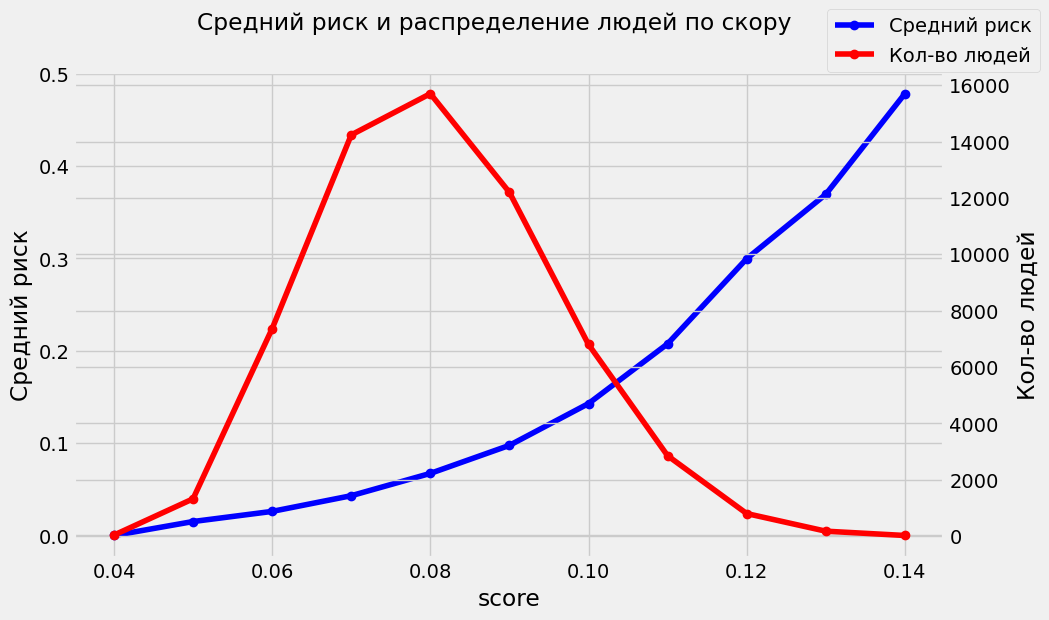

In [709]:
train_and_evaluate_logreg(appl_bureu_train_id, appl_bureu_test_id, \
                            appl_bureu_train, appl_bureu_train_labels, \
                            appl_bureu_test, appl_bureu_test_labels)

## Gradient Boosting with bureu

[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15755
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 137
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
ROC-AUC: 0.7613
Accuracy: 0.9198

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56554
           1       0.55      0.02      0.04      4949

    accuracy                           0.92     61503
   macro avg       0.73      0.51      0.50     61503
weighted avg       0.89      0.92      0.88     61503



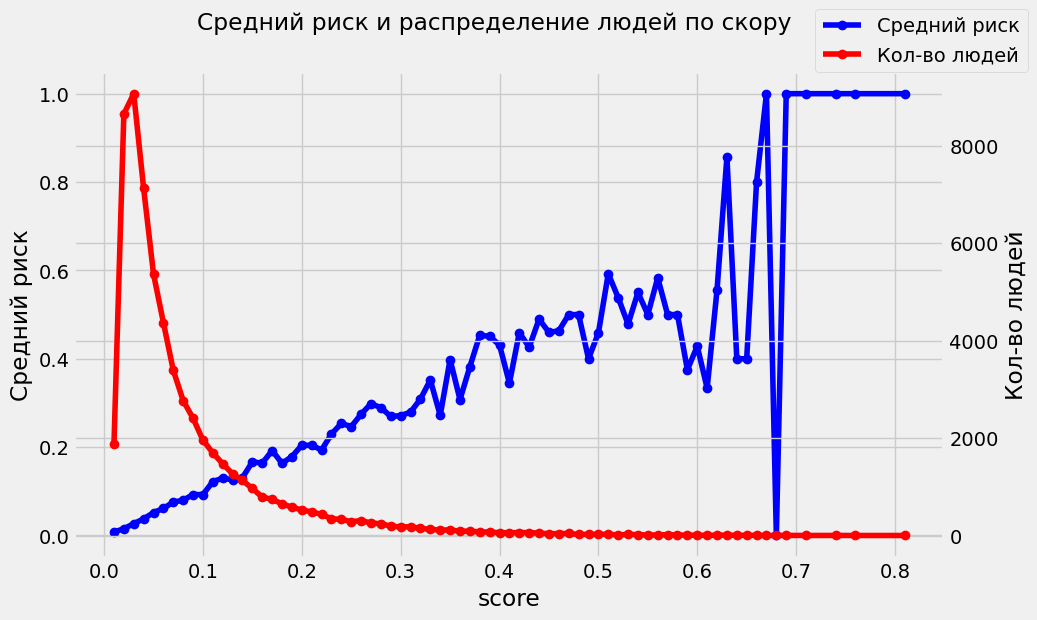

<Figure size 1200x800 with 0 Axes>

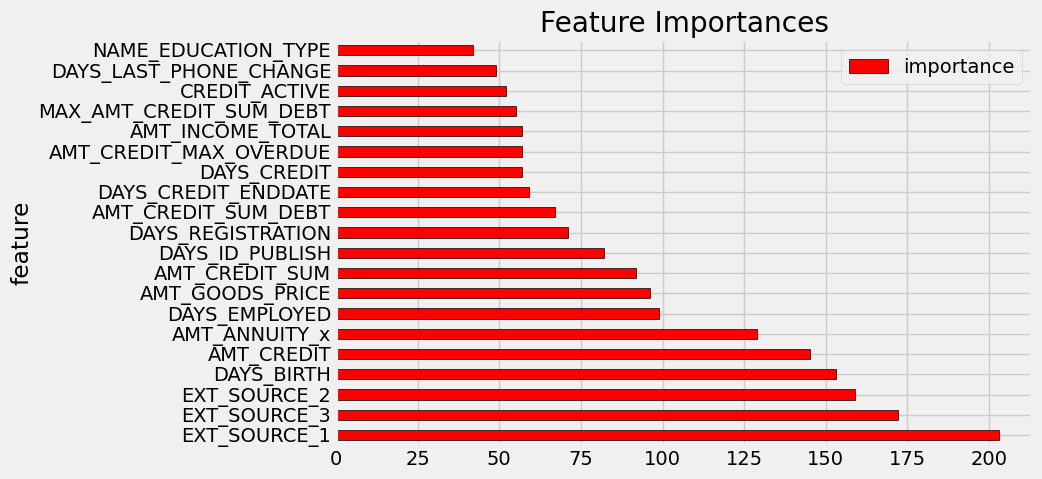

In [711]:
train_and_evaluate_boosting(appl_bureu_train_id, appl_bureu_test_id, \
                            appl_bureu_train, appl_bureu_train_labels, \
                            appl_bureu_test, appl_bureu_test_labels)

## CatBoostClassifier with bureu

ROC-AUC: 0.7676
Accuracy: 0.9198

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56554
           1       0.53      0.03      0.05      4949

    accuracy                           0.92     61503
   macro avg       0.73      0.51      0.50     61503
weighted avg       0.89      0.92      0.89     61503



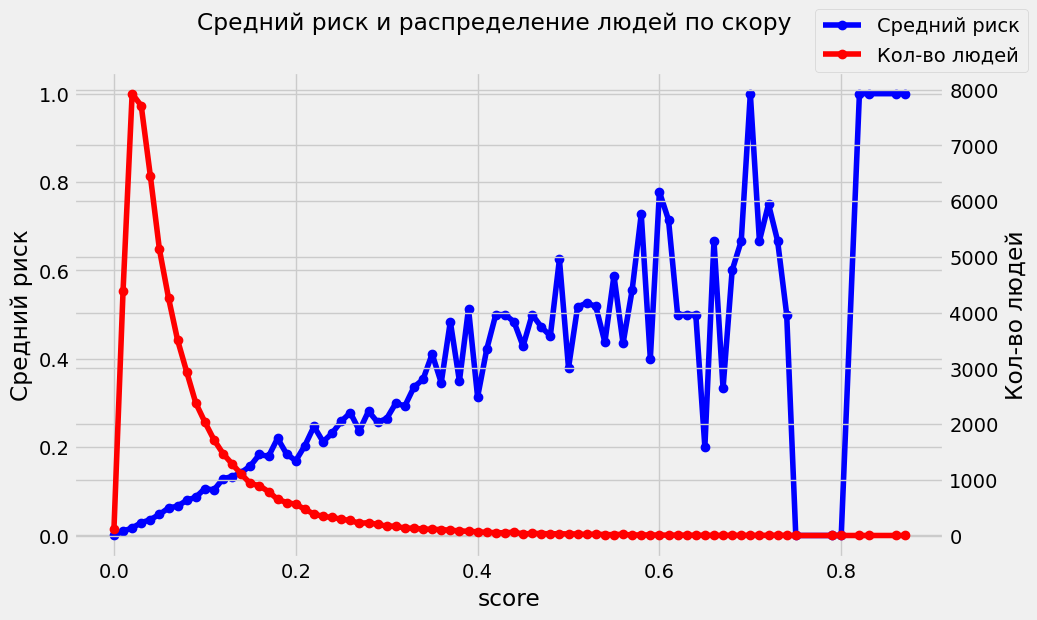

<Figure size 1200x800 with 0 Axes>

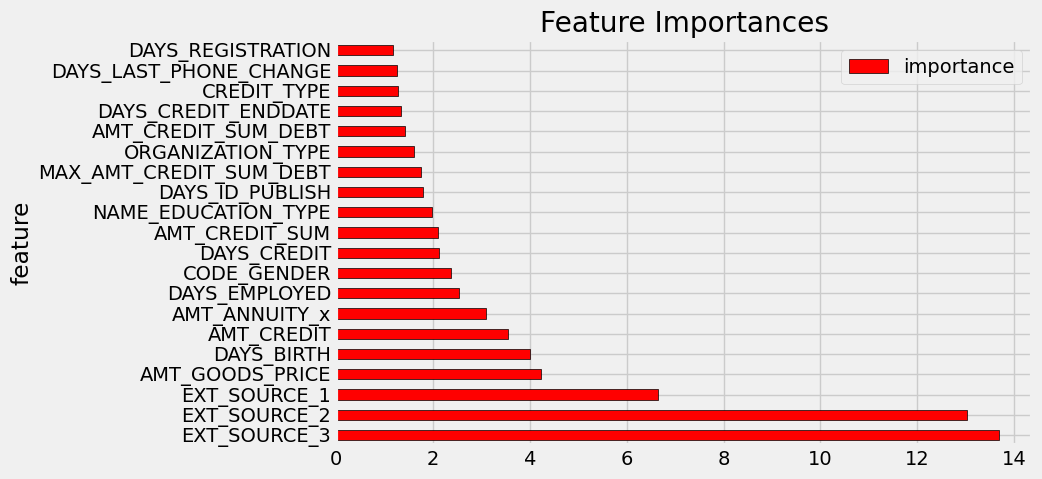

In [713]:
train_and_evaluate_catboost(appl_bureu_train_id, appl_bureu_test_id, \
                            appl_bureu_train, appl_bureu_train_labels, \
                            appl_bureu_test, appl_bureu_test_labels)